In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
import tensorflow as tf
import tensorflow.keras as K


from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [ ]:
os.mkdir('/content/Crop-Brain-MRI')
os.mkdir('/content/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/content/Crop-Brain-MRI/no_tumor')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.mkdir('/content/Test-Data')
os.mkdir('/content/Test-Data/glioma_tumor')
os.mkdir('/content/Test-Data/meningioma_tumor')
os.mkdir('/content/Test-Data/pituitary_tumor')
os.mkdir('/content/Test-Data/no_tumor')

In [ ]:
train_dir = '/content/drive/MyDrive/majorProject/Dataset_Old/Training/'
test_dir = '/content/drive/MyDrive/majorProject/Dataset_Old/Testing/'

In [ ]:
classes = os.listdir('/content/drive/MyDrive/majorProject/Dataset_Old/Training')
classes

['no_tumor', 'glioma_tumor', 'pituitary_tumor', 'meningioma_tumor']

In [ ]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))


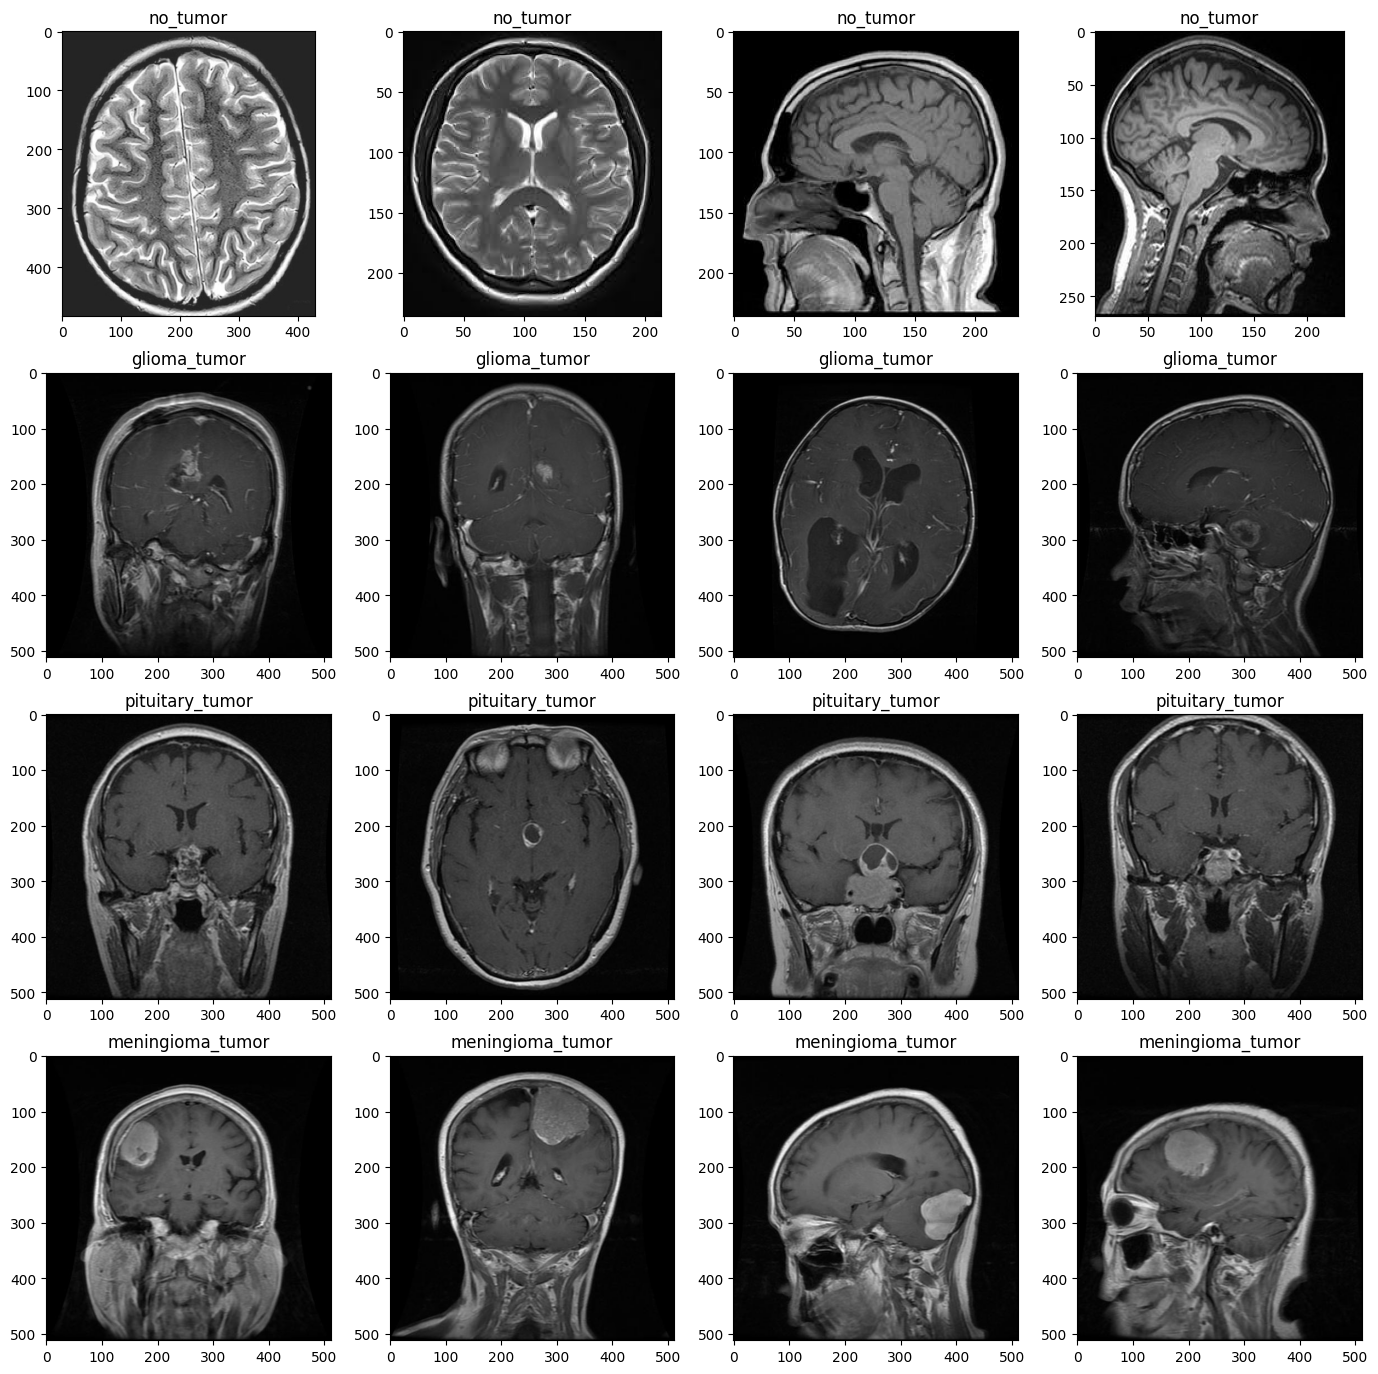

In [ ]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [ ]:
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/drive/MyDrive/majorProject/Dataset_Old/Training'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/majorProject/Dataset_Old/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in no_tumor = 395 

Number of images in glioma_tumor = 836 

Number of images in pituitary_tumor = 827 

Number of images in meningioma_tumor = 822 



In [ ]:
def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

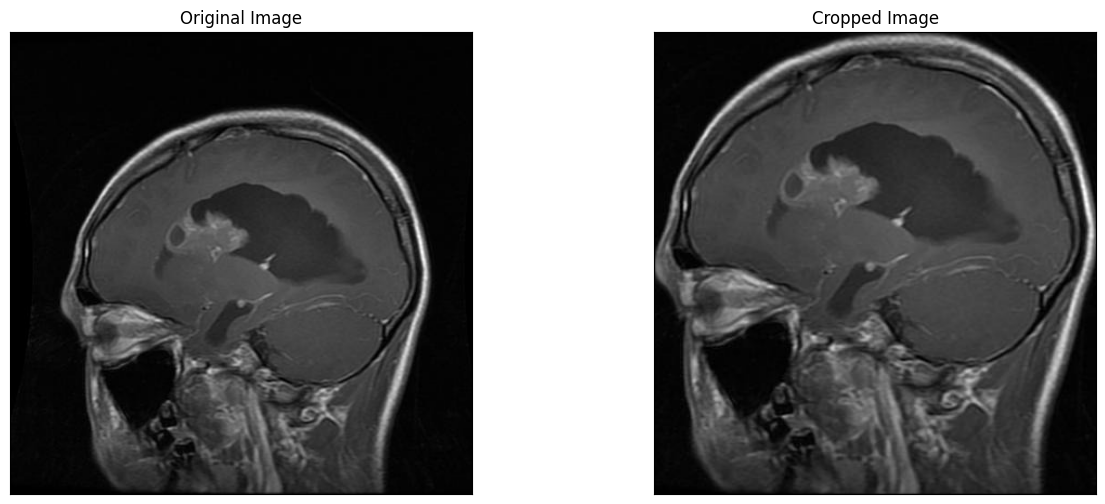

In [ ]:
example_image = cv2.imread('/content/tumor_dataset/Brain-MRI/Training/glioma_tumor/gg (60).jpg')
cropped_image = crop_image(example_image,plot = True)

In [ ]:
image_size = 240
input_shape = (image_size, image_size, 3)
epoch = 10
lr = 0.0001
batch_size = 32

In [ ]:
glioma = train_dir + 'glioma_tumor'
meningioma = train_dir + 'meningioma_tumor'
pituitary = train_dir + 'pituitary_tumor'
no_tumor = train_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 395/395 [00:04<00:00, 80.59it/s] 


In [ ]:
test_glioma = test_dir + 'glioma_tumor'
test_meningioma = test_dir + 'meningioma_tumor'
test_pituitary = test_dir + 'pituitary_tumor'
test_no_tumor = test_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (image_size, image_size))
    save_path = '/content/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 105/105 [00:02<00:00, 51.51it/s]


In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(image_size, image_size),
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         subset='training')
valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(image_size, image_size),
                                         batch_size=batch_size,
                                         class_mode='categorical',
                                         subset='validation')
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size=(image_size, image_size),
                                        class_mode='categorical',
                                        shuffle=False)


Found 2305 images belonging to 4 classes.
Found 575 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
from tensorflow.keras import layers, models

In [ ]:
model = Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),

        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 240, 240, 64)      1792      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 120, 120, 64)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_13 (Ba  (None, 120, 120, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_14 (Conv2D)          (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                      

In [ ]:
model.compile(optimizer=Adam(learning_rate = lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint('content/drive/MyDrive/SCNN.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [ ]:
%%time

history = model.fit(train_data,
                    epochs = epoch,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/10
73/73 [==============================] - ETA: 0s - loss: 0.9953 - accuracy: 0.5948 
Epoch 1: val_accuracy improved from -inf to 0.14435, saving model to content/drive/MyDrive/SCNN.h5
73/73 [==============================] - 1227s 17s/step - loss: 0.9953 - accuracy: 0.5948 - val_loss: 2.8040 - val_accuracy: 0.1443 - lr: 1.0000e-04
Epoch 2/10
73/73 [==============================] - ETA: 0s - loss: 0.7742 - accuracy: 0.6785 
Epoch 2: val_accuracy improved from 0.14435 to 0.45043, saving model to content/drive/MyDrive/SCNN.h5
73/73 [==============================] - 1222s 17s/step - loss: 0.7742 - accuracy: 0.6785 - val_loss: 1.2187 - val_accuracy: 0.4504 - lr: 1.0000e-04
Epoch 3/10
73/73 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7380 
Epoch 3: val_accuracy improved from 0.45043 to 0.50435, saving model to content/drive/MyDrive/SCNN.h5
73/73 [==============================] - 1251s 17s/step - loss: 0.6656 - accuracy: 0.7380 - val_loss: 1.1519 - val

In [ ]:
model.save('/content/drive/MyDrive/majorProject/Save_Models/SCNN_Model.h5')

In [ ]:
import matplotlib.pyplot as plt

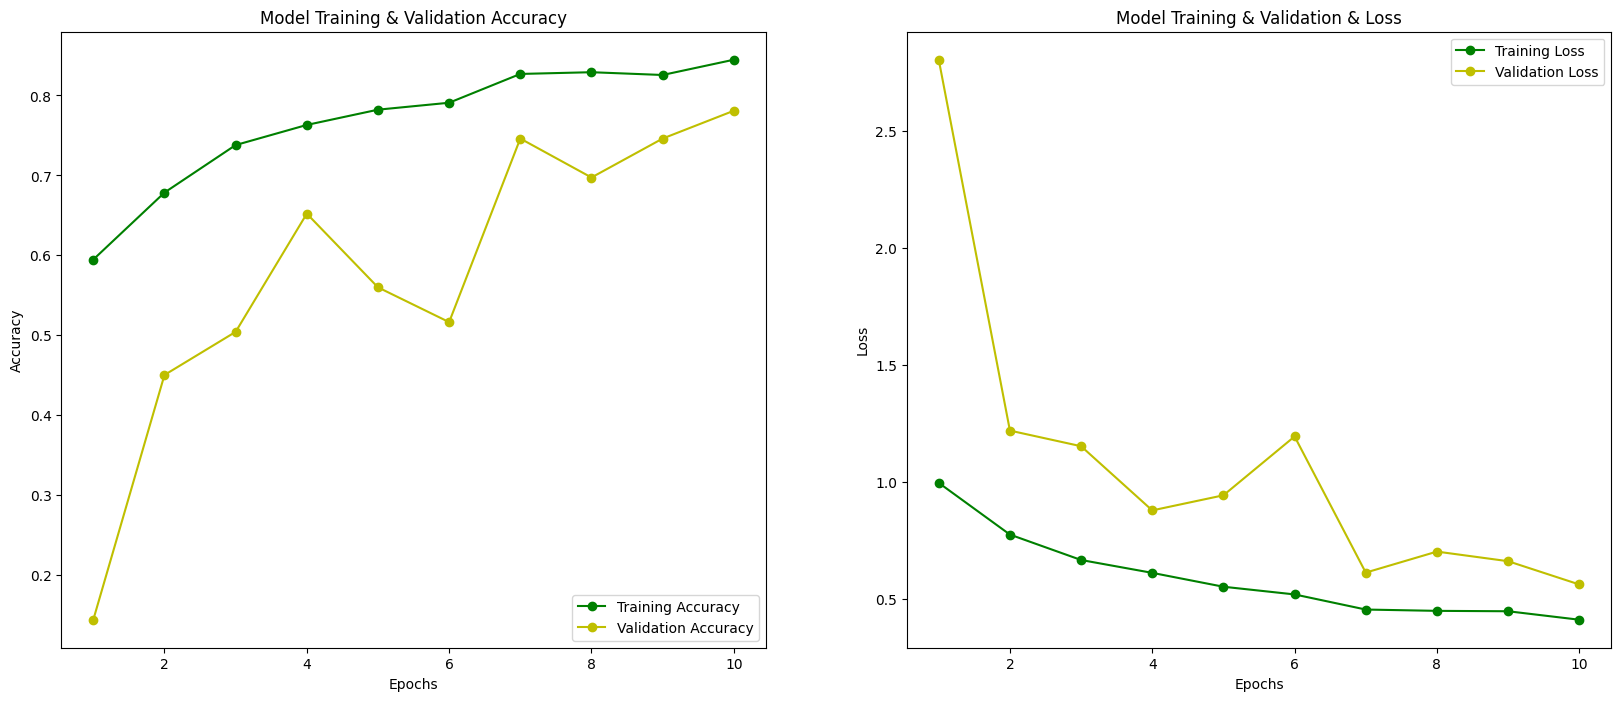

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

73/73 [==============================] - 348s 5s/step - loss: 0.3779 - accuracy: 0.8620
Train accuracy & loss: [0.3778827488422394, 0.8620390295982361]


13/13 [==============================] - 59s 4s/step - loss: 2.1758 - accuracy: 0.5000
Test accuracy & loss: [2.1758272647857666, 0.5]


In [ ]:
y_test = test_data.classes

yhat_test = np.argmax(model.predict(test_data), axis=1)


13/13 [==============================] - 59s 4s/step


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[ 19  22  56   3]
 [  1  53  57   4]
 [  1   3 100   1]
 [  3  13  26  32]]


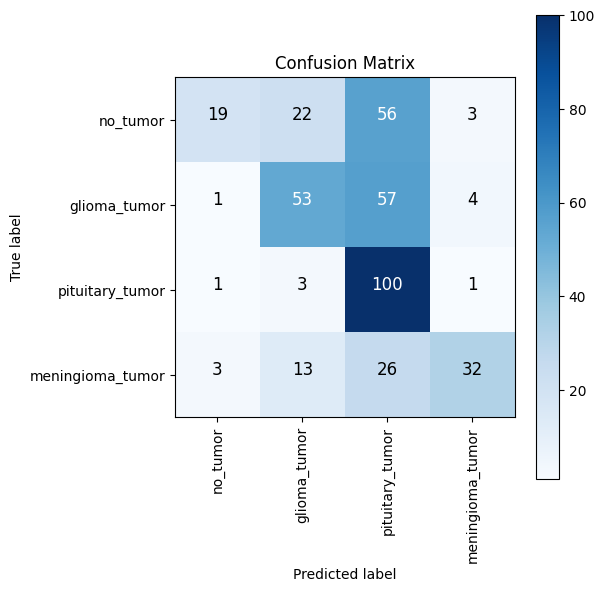

In [ ]:
cm = confusion_matrix(y_test, yhat_test)
print(cm)

plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.79      0.19      0.31       100
           1       0.58      0.46      0.51       115
           2       0.42      0.95      0.58       105
           3       0.80      0.43      0.56        74

    accuracy                           0.52       394
   macro avg       0.65      0.51      0.49       394
weighted avg       0.63      0.52      0.49       394

